<a href="https://colab.research.google.com/github/shishiraiyar/ship-detection/blob/main/ship.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Upload kaggle.json

!pip install kaggle
!mkdir .kaggle
!mv kaggle.json .kaggle/kaggle.json
!chmod 600 .kaggle/kaggle.json

In [ ]:
!kaggle datasets download rhammell/ships-in-satellite-imagery

Dataset URL: https://www.kaggle.com/datasets/rhammell/ships-in-satellite-imagery
License(s): CC-BY-SA-4.0
 90% 167M/185M [00:00<00:00, 188MB/s]
100% 185M/185M [00:01<00:00, 181MB/s]


In [ ]:
!unzip -q ships-in-satellite-imagery.zip

In [ ]:
import os
import datetime
from PIL import Image
import matplotlib.pyplot as plt

import torch
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader, random_split
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Training on device {device}")

Training on device cuda


In [ ]:
class ImageDataset(Dataset):
  def __init__(self, path, transform=None):
    self.path = path
    self.transform = transform
    self.image_files = [f for f in os.listdir(path) if f.endswith((".png"))]

  def __len__(self):
    return len(self.image_files)

  def __getitem__(self, idx):
    image_file = self.image_files[idx]
    image_path = os.path.join(self.path, image_file)

    image = Image.open(image_path).convert('RGB')

    label = int(image_file.split("__")[0])

    if self.transform:
      image = self.transform(image)

    return image, label

In [ ]:
data_path = "shipsnet/shipsnet"

dataset = ImageDataset(data_path, transform = transforms.ToTensor())

len(dataset)

4000

In [ ]:
images = [t[0] for t in dataset]
img_t = torch.stack(images, dim=3).view(3, -1)
mean = img_t.mean(dim=1)
std = img_t.std(dim=1)
mean, std

(tensor([0.4119, 0.4243, 0.3724]), tensor([0.1899, 0.1569, 0.1515]))

In [ ]:
normalized_dataset = ImageDataset(data_path, transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=mean, std=std)
]))

In [ ]:
train_test_split = 0.2

test_size = int(train_test_split * len(normalized_dataset))
train_size = len(normalized_dataset) - test_size

train_dataset, test_dataset = random_split(dataset, [train_size, test_size])
len(train_dataset), len(test_dataset)

(3200, 800)

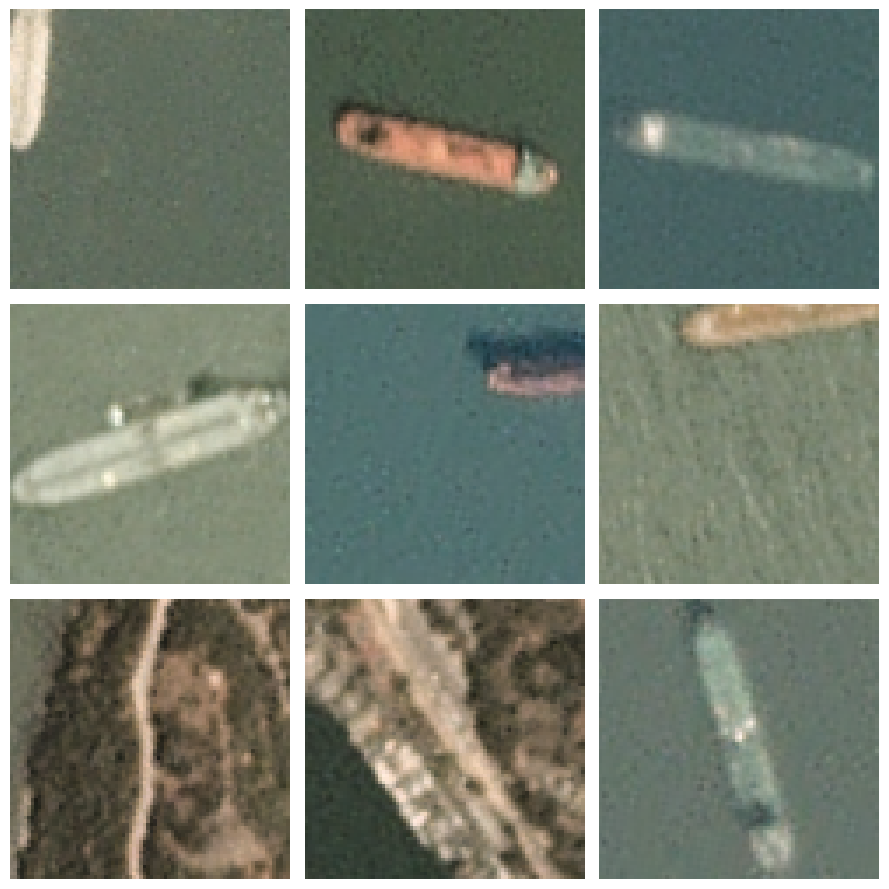

In [ ]:
fig, axes = plt.subplots(3, 3, figsize=(9, 9))

for i, ax in enumerate(axes.flat):
  ax.imshow(train_dataset[50 + i][0].permute(1, 2, 0))
  ax.axis('off')
plt.tight_layout()
plt.show()

In [ ]:
batch_size = 64

train_dataloader = DataLoader(train_dataset, batch_size = 64, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size = 64, shuffle=False)

for imgs, labels in train_dataloader:
  print(imgs.shape, labels.shape)
  break

torch.Size([64, 3, 80, 80]) torch.Size([64])


In [ ]:
def listParameters(model):
  numel_list = [p.numel() for p in model.parameters()]
  return sum(numel_list), numel_list

In [ ]:
def correct_count(logits, labels):
  probs = torch.sigmoid(logits)
  predictions = (probs > 0.5).long()
  correct = int((predictions == labels).sum())
  return correct

In [ ]:
def forward_pass(imgs, labels, model, loss_fn, is_train):
  with torch.set_grad_enabled(is_train):
    imgs = imgs.to(device=device)
    labels = labels.to(device=device, dtype=torch.float).unsqueeze(dim=1)

    outputs = model(imgs)
    loss = loss_fn (outputs, labels)
    correct = correct_count(outputs, labels)

    return loss, correct

In [ ]:
def training_loop(n_epochs, model, optimizer, loss_fn, train_loader, test_loader):
  history = {"loss_train": [], "accuracy_train": [] , "loss_val": [], "accuracy_val": []}
  for epoch in range(1, n_epochs + 1):
    loss_train = 0.0
    correct_train = 0

    loss_val = 0.0
    correct_val = 0

    for imgs, labels in test_loader:
      loss, correct = forward_pass(imgs, labels, model, loss_fn, False)
      loss_val += loss.item()
      correct_val += correct

    for imgs, labels in train_loader:
      loss, correct = forward_pass(imgs, labels, model, loss_fn, True)

      loss_train += loss.item()
      correct_train += correct

      optimizer.zero_grad()
      loss.backward()
      optimizer.step()


    loss_train = loss_train / len(train_loader)
    accuracy_train = correct_train / len(train_loader.dataset)

    loss_val = loss_val / len(test_dataloader)
    accuracy_val = correct_val / len(test_loader.dataset)

    print("{} Epoch {}, Training loss {:.2f}, Training accuracy {:2f}, \
Validation loss {:2f}, Validation accuracy {:2f}".format(
        datetime.datetime.now(), epoch,
        loss_train,
        accuracy_train,
        loss_val,
        accuracy_val
    ))

    history["loss_train"].append(loss_train)
    history["accuracy_train"].append(accuracy_train)

    history["loss_val"].append(loss_val)
    history["accuracy_val"].append(accuracy_val)
  return history

In [ ]:
def plot_history(history):
  fig, ax = plt.subplots(1, 2, figsize=(15,6))
  ax[0].plot(history["loss_train"], label="Training Loss")
  ax[0].plot(history["loss_val"], label="Validation Loss")

  ax[0].set_xlabel("Epochs")
  ax[0].set_ylabel("Loss")
  ax[0].set_title("Training and Validation Loss vs Epochs")
  ax[0].legend()
  ax[0].grid(True)

  ax[1].plot(history["accuracy_train"], label="Training Accuracy")
  ax[1].plot(history["accuracy_val"], label="Validation Accuracy")
  ax[1].set_xlabel("Epochs")
  ax[1].set_ylabel("Accuracy")
  ax[1].set_title("Training and Validation Accuracy vs Epochs")
  ax[1].legend()
  ax[1].grid(True)

  plt.tight_layout()
  plt.show()

In [ ]:
class Modelv1(nn.Module):
  def __init__(self):
    super().__init__()
    self.conv1 = nn.Conv2d(3, 16, kernel_size=3, padding=1)
    self.conv2 = nn.Conv2d(16, 8, kernel_size=3, padding=1)


    self.fc1 = nn.Linear(20*20*8, 32)
    self.fc2 = nn.Linear(32, 1)


  def forward(self, x):
    out = self.conv1(x)
    out = F.relu(out)
    out = F.max_pool2d(out, 2)

    out = self.conv2(out)
    out = F.relu(out)
    out = F.max_pool2d(out, 2)

    out = out.view(-1, 20 * 20 * 8)

    out = self.fc1(out)
    out = F.relu(out)
    out = self.fc2(out)
    return out

model = Modelv1().to(device=device)
print("Parameter count: ", listParameters(model))

Parameter count:  (104073, [432, 16, 1152, 8, 102400, 32, 32, 1])


In [ ]:
learning_rate = 1e-2
optimizer = optim.SGD(model.parameters(), lr=learning_rate)
loss_fn = nn.BCEWithLogitsLoss()

In [ ]:
history = training_loop(100, model, optimizer, loss_fn, train_dataloader, test_dataloader)

2024-12-13 14:18:46.175820 Epoch 1, Training loss 0.62, Training accuracy 0.658438, Validation loss 0.733670, Validation accuracy 0.247500
2024-12-13 14:18:50.408126 Epoch 2, Training loss 0.54, Training accuracy 0.749375, Validation loss 0.548303, Validation accuracy 0.752500
2024-12-13 14:18:54.772208 Epoch 3, Training loss 0.52, Training accuracy 0.750000, Validation loss 0.530341, Validation accuracy 0.752500
2024-12-13 14:18:59.093395 Epoch 4, Training loss 0.47, Training accuracy 0.775312, Validation loss 0.501627, Validation accuracy 0.755000
2024-12-13 14:19:03.387666 Epoch 5, Training loss 0.41, Training accuracy 0.821562, Validation loss 0.446635, Validation accuracy 0.791250
2024-12-13 14:19:07.696807 Epoch 6, Training loss 0.36, Training accuracy 0.846250, Validation loss 0.383607, Validation accuracy 0.833750
2024-12-13 14:19:11.092344 Epoch 7, Training loss 0.34, Training accuracy 0.848750, Validation loss 0.356775, Validation accuracy 0.836250
2024-12-13 14:19:13.994543 

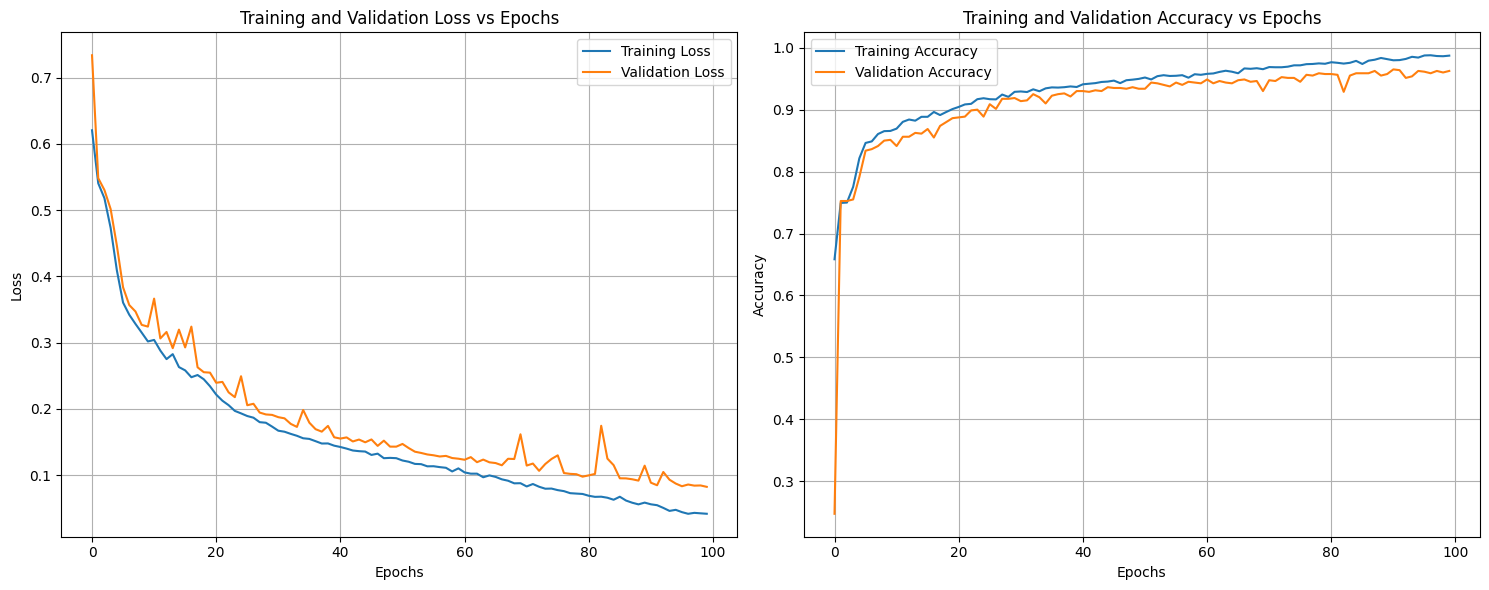

In [ ]:
plot_history(history)

In [ ]:
class Modelv2(nn.Module):
  def __init__(self):
    super().__init__()
    self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
    self.conv2 = nn.Conv2d(32, 16, kernel_size=3, padding=1)
    self.conv3 = nn.Conv2d(16, 8, kernel_size=3, padding=1)

    self.fc1 = nn.Linear(10*10*8, 32)
    self.fc2 = nn.Linear(32, 1)


  def forward(self, x):
    out = self.conv1(x)
    out = F.relu(out)
    out = F.max_pool2d(out, 2)

    out = self.conv2(out)
    out = F.relu(out)
    out = F.max_pool2d(out, 2)

    out = self.conv3(out)
    out = F.relu(out)
    out = F.max_pool2d(out, 2)

    out = out.view(-1, 10 * 10 * 8)

    out = self.fc1(out)
    out = F.relu(out)
    out = self.fc2(out)
    return out

model = Modelv2().to(device=device)
print("Parameter count: ", listParameters(model))

Parameter count:  (32345, [864, 32, 4608, 16, 1152, 8, 25600, 32, 32, 1])


In [ ]:
learning_rate = 1e-2
optimizer = optim.SGD(model.parameters(), lr=learning_rate)
loss_fn = nn.BCEWithLogitsLoss()

In [ ]:
history = training_loop(100, model, optimizer, loss_fn, train_dataloader, test_dataloader)

2024-12-13 14:25:01.198510 Epoch 1, Training loss 0.70, Training accuracy 0.385000, Validation loss 0.730577, Validation accuracy 0.247500
2024-12-13 14:25:05.552677 Epoch 2, Training loss 0.63, Training accuracy 0.749375, Validation loss 0.676597, Validation accuracy 0.752500
2024-12-13 14:25:09.899410 Epoch 3, Training loss 0.56, Training accuracy 0.749375, Validation loss 0.572040, Validation accuracy 0.752500
2024-12-13 14:25:14.214040 Epoch 4, Training loss 0.55, Training accuracy 0.749375, Validation loss 0.547406, Validation accuracy 0.752500
2024-12-13 14:25:18.537943 Epoch 5, Training loss 0.53, Training accuracy 0.749375, Validation loss 0.538985, Validation accuracy 0.752500
2024-12-13 14:25:22.852825 Epoch 6, Training loss 0.51, Training accuracy 0.749375, Validation loss 0.525201, Validation accuracy 0.752500
2024-12-13 14:25:26.967162 Epoch 7, Training loss 0.46, Training accuracy 0.773750, Validation loss 0.494568, Validation accuracy 0.752500
2024-12-13 14:25:31.399729 

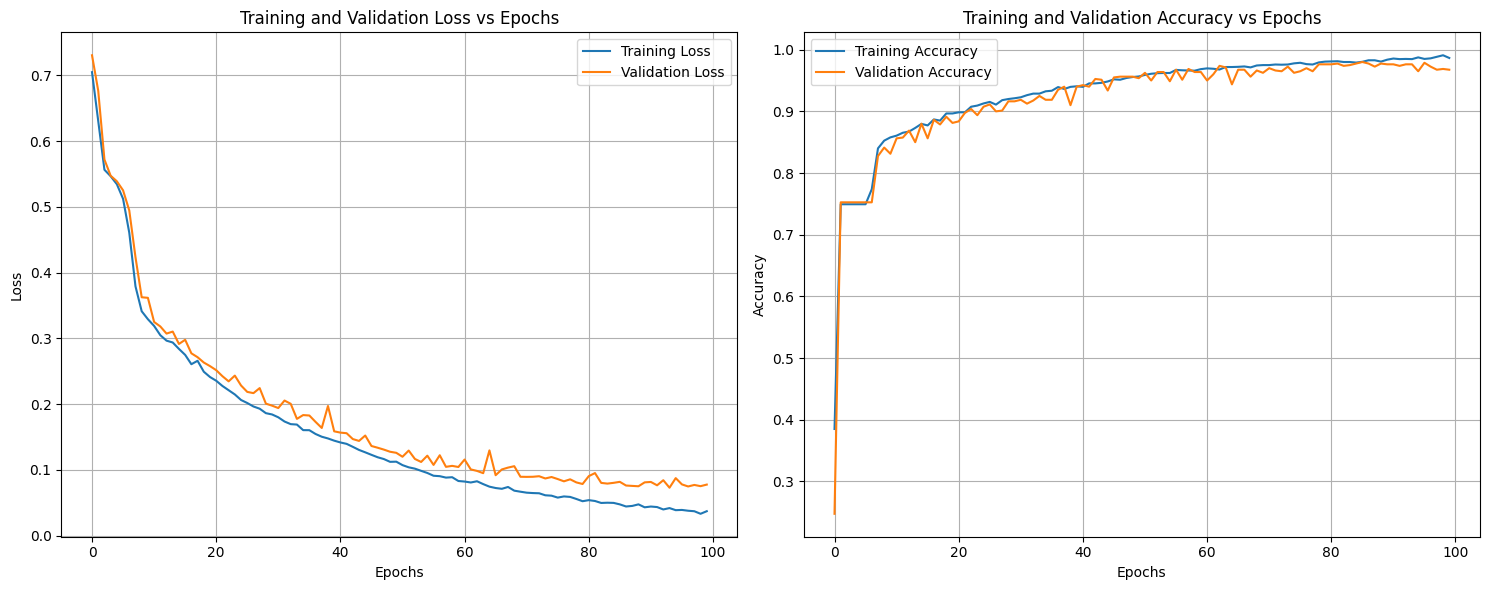

In [ ]:
plot_history(history)

In [ ]:
class Modelv3(nn.Module):
  def __init__(self):
    super().__init__()
    self.conv1 = nn.Conv2d(3, 16, kernel_size=3, padding=1)
    self.conv2 = nn.Conv2d(16, 8, kernel_size=3, padding=1)
    self.conv3 = nn.Conv2d(8, 4, kernel_size=3, padding=1)

    self.fc1 = nn.Linear(10*10*4, 32)
    self.fc2 = nn.Linear(32, 1)


  def forward(self, x):
    out = self.conv1(x)
    out = F.relu(out)
    out = F.max_pool2d(out, 2)

    out = self.conv2(out)
    out = F.relu(out)
    out = F.max_pool2d(out, 2)

    out = self.conv3(out)
    out = F.relu(out)
    out = F.max_pool2d(out, 2)

    out = out.view(-1, 10 * 10 * 4)

    out = self.fc1(out)
    out = F.relu(out)
    out = self.fc2(out)
    return out

model = Modelv3().to(device=device)
print("Parameter count: ", listParameters(model))

Parameter count:  (14765, [432, 16, 1152, 8, 288, 4, 12800, 32, 32, 1])


In [ ]:
learning_rate = 1e-3
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
loss_fn = nn.BCEWithLogitsLoss()

In [ ]:
history = training_loop(50, model, optimizer, loss_fn, train_dataloader, test_dataloader)

2024-12-13 14:31:27.443848 Epoch 1, Training loss 0.60, Training accuracy 0.666250, Validation loss 0.727103, Validation accuracy 0.247500
2024-12-13 14:31:31.775694 Epoch 2, Training loss 0.45, Training accuracy 0.793438, Validation loss 0.526164, Validation accuracy 0.752500
2024-12-13 14:31:35.499942 Epoch 3, Training loss 0.34, Training accuracy 0.876250, Validation loss 0.370745, Validation accuracy 0.865000
2024-12-13 14:31:38.367660 Epoch 4, Training loss 0.29, Training accuracy 0.906250, Validation loss 0.330584, Validation accuracy 0.871250
2024-12-13 14:31:41.242657 Epoch 5, Training loss 0.22, Training accuracy 0.917188, Validation loss 0.279552, Validation accuracy 0.906250
2024-12-13 14:31:44.120929 Epoch 6, Training loss 0.18, Training accuracy 0.923125, Validation loss 0.217801, Validation accuracy 0.912500
2024-12-13 14:31:48.123476 Epoch 7, Training loss 0.16, Training accuracy 0.929375, Validation loss 0.184839, Validation accuracy 0.921250
2024-12-13 14:31:52.482670 

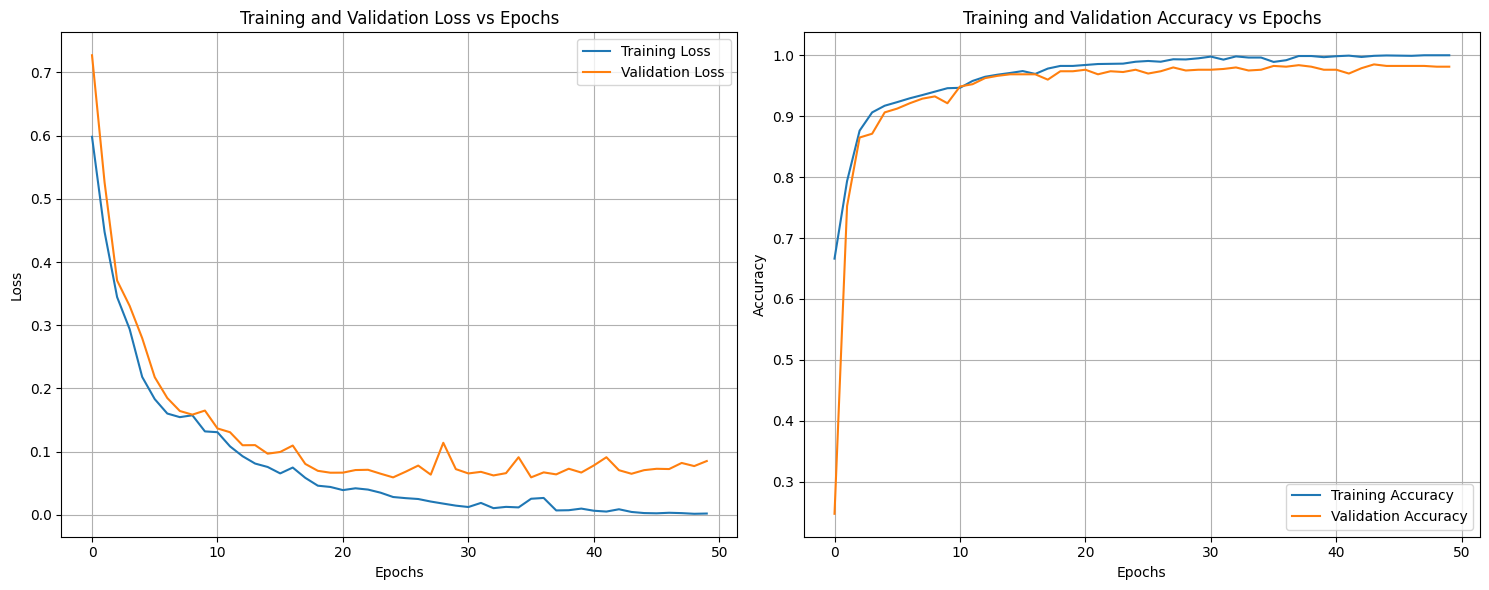

In [ ]:
plot_history(history)

In [ ]:
model_scripted = torch.jit.script(model)
model_scripted.save('model_scripted.pt')